In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
import statsmodels.stats.multitest as multi

   Hugo_Symbol  counts_x  counts_y  poisson_p_tail1  poisson_p_tail2
0        ASXL1        20      17.0         0.815544                1
1       DNMT3A        75      79.0         0.295881                1
2         GNB1         5       5.0         0.814849                1
3       HIVEP2         7       5.0         0.695684                1
4         JAK2         6      14.0         0.002059                1
5     KIAA0141         3       0.0         0.126067                1
6        KRBA2         3       0.0         0.126067                1
7   LY75-CD302         3       0.0         0.126067                1
8        PPM1D        11       5.0         0.115258                1
9        SF3B1        20      11.0         0.079475                1
10       SRCAP         8       6.0         0.715317                1
11        TET2        26      36.0         0.023889                1
12        TP53         8       6.0         0.715317                1
13      ZBTB33        10       5.0

/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:90: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/mleventh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


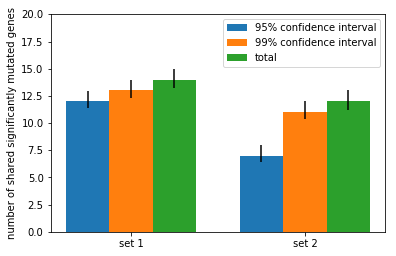

In [38]:
## Requires that the mutation calling file be split into two halves. 
## performs a binomial test to identify if the significantly mutated genes in one set occurs at a similar rate
## in the other set
input1="set1.txt"
input2="set2.txt"
set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

set1_size=len(set1['Tumor_Sample_Barcode'].unique())
set2_size=len(set2['Tumor_Sample_Barcode'].unique())

#read the first set of significantly mutated genes and limit the list to those with a q-value less than 0.1
sig_list="sig_genes_set1"
sig_gene_valid=pd.read_csv(sig_list,sep='\t')
sig_gene_valid=sig_gene_valid[sig_gene_valid['q']<0.1]

#count number of mutations in each significantly mutated gene
set1=set1.loc[set1['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]
set2=set2.loc[set2['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

#merge counts and if a gene is not in the other set, call counts as 0
valid_merge=valid1_counts.merge(valid2_counts,how="outer",on=["Hugo_Symbol"])
valid_merge=valid_merge.fillna(0)

#set default probability
valid_merge["binomial_p"]=1

for idx,row in valid_merge.iterrows():
        valid_merge.loc[idx,"binomial_p"]=stats.binom_test(row['counts_y'],set2_size,
                                                               row['counts_x']/set1_size)

#next, test significantly mutated genes in the second set
set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

sig_list="sig_genes_set2.txt"
sig_gene_valid=pd.read_csv(sig_list,sep='\t')

sig_gene_valid=sig_gene_valid[sig_gene_valid['q']<0.1]
set1=set1.loc[set1['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]
set2=set2.loc[set2['Hugo_Symbol'].isin(sig_gene_valid['gene']),:]

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge2=valid2_counts.merge(valid1_counts,how="outer",on=["Hugo_Symbol"])

valid_merge2=valid_merge2.fillna(0)
valid_merge2["binomial_p"]=1
for idx,row in valid_merge2.iterrows():
    valid_merge2.loc[idx,"binomial_p"]=stats.binom_test(row['counts_y'],set1_size,
                                                                row['counts_x']/set2_size)


#calculate the number of genes found in the 95% confidence interval
overlap1=[len(valid_merge[(valid_merge['binomial_p']>0.05)].index),
         len(valid_merge2[(valid_merge2['binomial_p']>0.05)].index)]

#calculate the number of genes found in the 99% confidence interval
overlap2=[len(valid_merge[(valid_merge['binomial_p']>0.01)].index),
         len(valid_merge2[(valid_merge2['binomial_p']>0.01)].index)]
                                                                  
    
#calculate total number of significantly mutated genes
overlap3=[len(valid_merge.index),len(valid_merge2.index)]

#calculate 95% confidence intervals on the counts
ci_low_1_1, ci_upp_1_1 = proportion_confint(len(valid_merge[
    (valid_merge['binomial_p']>0.05)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')
                                            
ci_low_1_2, ci_upp_1_2 = proportion_confint(len(valid_merge[
    (valid_merge['binomial_p']>0.01)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_1_3, ci_upp_1_3 = proportion_confint(len(valid_merge.index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_2_1, ci_upp_2_1 = proportion_confint(len(valid_merge2[
    (valid_merge['binomial_p']>0.05)].index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')
                                            
ci_low_2_2, ci_upp_2_2 = proportion_confint(len(valid_merge2[
    (valid_merge['binomial_p']>0.01)].index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')

ci_low_2_3, ci_upp_2_3 = proportion_confint(len(valid_merge2.index),
                                        len(valid_merge2.index), alpha=0.05, method='binom_test')

#plot results
plt.gcf().clear()

axes=plt.gca()
axes.set_ylim([0,20])

barWidth = 0.25
r1 = np.arange(len(overlap1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

p1=plt.bar(r1, overlap1,width=barWidth,label="95% confidence interval")
plt.errorbar(r1[0],overlap1[0], yerr=np.array([[ci_low_1_1,ci_upp_1_1]]).T,ecolor='black')
plt.errorbar(r1[1],overlap1[1], yerr=np.array([[ci_low_2_1,ci_upp_2_1]]).T,ecolor='black')
p2=plt.bar(r2, overlap2,width=barWidth,label="99% confidence interval")
plt.errorbar(r2[0],overlap2[0], yerr=np.array([[ci_low_1_2,ci_upp_1_2]]).T,ecolor='black')
plt.errorbar(r2[1],overlap2[1], yerr=np.array([[ci_low_2_2,ci_upp_2_2]]).T,ecolor='black')
p3=plt.bar(r3, overlap3,width=barWidth,label="total")
plt.errorbar(r3[0],overlap3[0], yerr=np.array([[ci_low_1_3,ci_upp_1_3]]).T,ecolor='black')
plt.errorbar(r3[1],overlap3[1], yerr=np.array([[ci_low_2_3,ci_upp_2_3]]).T,ecolor='black')
plt.xticks([r + barWidth for r in range(len(overlap1))], ('set 1', 'set 2','set 3'))
plt.ylabel('number of shared significantly mutated genes')
plt.legend()

plt.savefig("statistical_validation.png")


In [23]:
#test if counts of overlapping genes is within poisson expectation
print([stats.poisson.cdf(overlap1[0],overlap3[0]),stats.poisson.cdf(overlap2[0],overlap3[0]),
       stats.poisson.cdf(overlap1[1],overlap3[1]),stats.poisson.cdf(overlap2[1],overlap3[1])])

[0.15502778176746304, 0.10129100743983788, 0.2600399224594338, 0.17279938076448687]


In [ ]:
## binomial test for comparing to whitelisted CHIP calls##
input1="discovery.txt"
input2="chip_whitelist.txt"
set1=pd.read_csv(input1,sep='\t')
set2=pd.read_csv(input2,sep='\t')

print(len(set2['Tumor_Sample_Barcode'].unique()))

sig_genes=pd.read_csv("sig_genes.txt",sep='\t')
sig_genes=sig_genes[sig_genes['q']<0.1]
sig_genes=sig_genes.reset_index(drop=True)

#make sure the whitelisted calls have been filtered like the discovery set
set2=set2[set2['keep_max.1']>60]
set2=set2[set2['i_t_lod_fstar']>8.6]
print(len(set2['Tumor_Sample_Barcode'].unique()))

set1=set1.loc[set1['Hugo_Symbol'].isin(sig_genes['gene']),:]
set1=set1.reset_index(drop=True)

#filter out silent sites in discovery set
set1=set1.loc[~set1['Variant_Classification'].str.match("Silent"),:]
set1=set1.reset_index(drop=True)

set2=set2.loc[set2['Hugo_Symbol'].isin(sig_genes['gene']),:]
set2=set2.reset_index(drop=True)

valid1_counts=set1.groupby(['Hugo_Symbol']).size().reset_index(name='counts')
valid2_counts=set2.groupby(['Hugo_Symbol']).size().reset_index(name='counts')

valid_merge=valid1_counts.merge(valid2_counts,how="outer",on=["Hugo_Symbol"])

valid_merge=valid_merge.fillna(0)

#for pathogenic sites prior is 0.49, for all exonic mutations it is 0.61
for idx,row in valid_merge.iterrows():
    valid_merge.loc[idx,"binom_p"]=stats.binom_test(row['counts_x'],len(set1['Tumor_Sample_Barcode'].unique()),
                                                          0.49*row['counts_y']/len(set2['Tumor_Sample_Barcode'].unique()))

#get overlap with the 99% confidence interval
overlap2=[len(valid_merge[(valid_merge['binom_p_tail1']>0.01)].index)]

overlap3=[len(valid_merge.index)]

#print number of overlaps and total
print([overlap2,overlap3])
                                           
ci_low_1_2, ci_upp_1_2 = proportion_confint(len(valid_merge[
    (valid_merge['binom_p']>0.01)].index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

ci_low_1_3, ci_upp_1_3 = proportion_confint(len(valid_merge.index),
                                        len(valid_merge.index), alpha=0.05, method='binom_test')

plt.gcf().clear()


barWidth = 0.25

p2=plt.bar([0], overlap2,
           width=barWidth,color=['grey'],edgecolor='black')
plt.errorbar([0],overlap2[0], yerr=np.array([[ci_low_1_2,ci_upp_1_2]]).T,ecolor='black')
p3=plt.bar([0.35], overlap3,width=barWidth,color=['grey'],edgecolor='black')
plt.errorbar([0.35],overlap3[0], yerr=np.array([[ci_low_1_3,ci_upp_1_3]]).T,ecolor='black')
plt.xticks([0.0,0.35], ('99% confidence interval overlap', 'total'))
plt.ylabel("gene sets")
plt.ylabel('number of shared significantly mutated genes')

plt.savefig("CHIP_overlaps.png")

